# 대회 개요


## 주제
- 공기압축기 이상 판단(제4회 2023 연구개발특구 AI SPARK 챌린지)
- 산업기기 피로도를 예측하는 문제

## 모델 조건
- 모델링은 비지도학습 방식으로 진행
- 입력된 데이터를 정상(0), 이상(1)로 구분하는 이진 분류 모델
- 시간 단위로 생성되는 입력 데이터에 대하여 판정을 수행할 수 있는 모델
- 신규 데이터로 학습/개선이 가능한 모델
- 외부 공공 데이터 사용 가능

## 기타 중요 내용
- 반드시 리더보드상의 순위 기록에 해당되는 버전의 코드/모델 가중치를 제출
- 소스코드 내의 모든 무작위성은 seed 설정을 통해 통제

# 데이터 불러오기

* train_data
    * 학습용 데이터 
    * 모두 정상 case로 이루어짐
    * (2463 * 8)
* test_data
    * 평가용 데이터
    * 정상 case와 이상 case가 함께 포함됨
    * (7389 * 8)

* 구성
    - air_inflow: 공기 흡입 유량 (^3/min)
    - air_end_temp: 공기 말단 온도 (°C)
    - out_pressure: 토출 압력 (Mpa)
    - motor_current: 모터 전류 (A)
    - motor_rpm: 모터 회전수 (rpm)
    - motor_temp: 모터 온도 (°C)
    - motor_vibe: 모터 진동 (mm/s)
    - type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP


In [27]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
train_data = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/train_data.csv")
test_data= pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/test_data.csv")

In [13]:
drop_col = 'type'
train_data.drop(drop_col, axis=1, inplace=True)
test_data.drop(drop_col, axis=1, inplace=True)

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
dtypes: float64(7)
memory usage: 134.8 KB


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7389 entries, 0 to 7388
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     7389 non-null   float64
 1   air_end_temp   7389 non-null   float64
 2   out_pressure   7389 non-null   float64
 3   motor_current  7389 non-null   float64
 4   motor_rpm      7389 non-null   float64
 5   motor_temp     7389 non-null   float64
 6   motor_vibe     7389 non-null   float64
dtypes: float64(7)
memory usage: 404.2 KB


# 데이터 전처리

### motor_vibe 이상치 대체

In [17]:
# 20HP 에서 motor_vibe값이 이상치로 판단되는 행 보간: 16개
train_data.loc[train_data['motor_vibe'] > 15.0, 'motor_vibe'] = np.nan

In [18]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
data_filled = imputer.fit_transform(train_data)
train_data = pd.DataFrame(data_filled, columns=train_data.columns)

### 새로운 Feature 추가하기

In [21]:
# 이전 시간대 대비 차이 계산 (delta)
df_delta = train_data.diff(periods=1)
df_delta.columns = [col+"_delta" for col in train_data.columns]

# 이전 시간대 대비 변화율 계산 (delta rate)
df_delta_rate = train_data.pct_change(periods=1)
df_delta_rate.columns = [col+"_delta_rate" for col in train_data.columns]

# 이동평균 계산 (moving average)
window_size = 5 # 윈도우 크기
df_ma = train_data.rolling(window_size).mean()
df_ma.columns = [col+"_ma" for col in train_data.columns]

# 상관관계 계산 (correlation)
df_corr = train_data.corr()

# 새로운 feature들을 데이터프레임에 추가하기
df_train = pd.concat([train_data, df_delta, df_delta_rate, df_ma], axis=1)

# # 상관관계 행렬을 csv 파일로 저장하기
# df_corr.to_csv("correlation_matrix.csv")

# 맨 처음과 맨 마지막 데이터의 결측치 처리하기
df_train = df_train.fillna(method="bfill").fillna(method="ffill")

In [22]:
# 이전 시간대 대비 차이 계산 (delta)
df_delta = test_data.diff(periods=1)
df_delta.columns = [col+"_delta" for col in test_data.columns]

# 이전 시간대 대비 변화율 계산 (delta rate)
df_delta_rate = test_data.pct_change(periods=1)
df_delta_rate.columns = [col+"_delta_rate" for col in test_data.columns]

# 이동평균 계산 (moving average)
window_size = 5 # 윈도우 크기
df_ma = test_data.rolling(window_size).mean()
df_ma.columns = [col+"_ma" for col in test_data.columns]

# 상관관계 계산 (correlation)
df_corr = test_data.corr()

# 새로운 feature들을 데이터프레임에 추가하기
df_test = pd.concat([test_data, df_delta, df_delta_rate, df_ma], axis=1)

# # 상관관계 행렬을 csv 파일로 저장하기
# df_corr.to_csv("correlation_matrix.csv")

# 맨 처음과 맨 마지막 데이터의 결측치 처리하기
df_test = df_test.fillna(method="bfill").fillna(method="ffill")

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   air_inflow                2463 non-null   float64
 1   air_end_temp              2463 non-null   float64
 2   out_pressure              2463 non-null   float64
 3   motor_current             2463 non-null   float64
 4   motor_rpm                 2463 non-null   float64
 5   motor_temp                2463 non-null   float64
 6   motor_vibe                2463 non-null   float64
 7   air_inflow_delta          2463 non-null   float64
 8   air_end_temp_delta        2463 non-null   float64
 9   out_pressure_delta        2463 non-null   float64
 10  motor_current_delta       2463 non-null   float64
 11  motor_rpm_delta           2463 non-null   float64
 12  motor_temp_delta          2463 non-null   float64
 13  motor_vibe_delta          2463 non-null   float64
 14  air_infl

In [23]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7389 entries, 0 to 7388
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   air_inflow                7389 non-null   float64
 1   air_end_temp              7389 non-null   float64
 2   out_pressure              7389 non-null   float64
 3   motor_current             7389 non-null   float64
 4   motor_rpm                 7389 non-null   float64
 5   motor_temp                7389 non-null   float64
 6   motor_vibe                7389 non-null   float64
 7   air_inflow_delta          7389 non-null   float64
 8   air_end_temp_delta        7389 non-null   float64
 9   out_pressure_delta        7389 non-null   float64
 10  motor_current_delta       7389 non-null   float64
 11  motor_rpm_delta           7389 non-null   float64
 12  motor_temp_delta          7389 non-null   float64
 13  motor_vibe_delta          7389 non-null   float64
 14  air_infl

# 모델링

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random

### seed 고정

In [28]:
def fix_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
fix_seed(42)

### 모델 정의

In [29]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim1),
#             nn.ReLU(),
#             nn.Linear(hidden_dim1, encoding_dim),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, hidden_dim1),
#             nn.ReLU(),
#             nn.Linear(hidden_dim1, input_dim),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [40]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, encoding_dim), # 추가된 히든 레이어
            nn.ReLU() # 추가된 히든 레이어
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim2), # 추가된 히든 레이어
            nn.ReLU(), # 추가된 히든 레이어
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### 학습

In [41]:
# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_train)
test_data_scaled = scaler.transform(df_test)

# Convert numpy arrays to torch tensors
train_data_scaled = torch.from_numpy(train_data_scaled).float()
test_data_scaled = torch.from_numpy(test_data_scaled).float()

In [42]:
# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 128
hidden_dim1 = 32
hidden_dim2 = 64

model = Autoencoder()

# Compile and train the autoencoder with early stopping
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

best_loss = float('inf')
patience = 10
count = 0

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=28, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=28, bias=True)
  )
)


In [43]:
model_name = 'timeSeriesFeature_hidden'

In [44]:
for epoch in range(10000):
    train_loss = 0
    for i in range(0, len(train_data_scaled), 32):
        inputs = train_data_scaled[i:i+32]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data_scaled)/32
    with torch.no_grad():
        val_loss = criterion(model(test_data_scaled), test_data_scaled)
        if val_loss < best_loss:
            count = 0
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
        else:
            count += 1
        if count >= patience:
            print("Early stopping!")
            break
    if epoch:
        print(f"Epoch {epoch}, train loss: {train_loss}, val loss: {val_loss.item()}")

Epoch 1, train loss: 0.36124087938486055, val loss: 0.23091384768486023
Epoch 2, train loss: 0.23221433153009202, val loss: 0.1715220808982849
Epoch 3, train loss: 0.1856225977280834, val loss: 0.1456751823425293
Epoch 4, train loss: 0.1526369580978598, val loss: 0.13385412096977234
Epoch 5, train loss: 0.13802994812498043, val loss: 0.1321771889925003
Epoch 6, train loss: 0.1320129198801503, val loss: 0.13111144304275513
Epoch 7, train loss: 0.12842921270764654, val loss: 0.1302219182252884
Epoch 8, train loss: 0.12576489486299391, val loss: 0.12850269675254822
Epoch 9, train loss: 0.12173175322927211, val loss: 0.12297560274600983
Epoch 10, train loss: 0.10538471926047557, val loss: 0.09164402633905411
Epoch 11, train loss: 0.06810669302698369, val loss: 0.08031047880649567
Epoch 12, train loss: 0.047520436095455726, val loss: 0.05637745186686516
Epoch 13, train loss: 0.03552525066719566, val loss: 0.06191476061940193
Epoch 14, train loss: 0.040818517237381384, val loss: 0.0872618779

### 결과 확인

In [45]:
# Calculate the reconstruction error for test_data
test_data_reconstructed = model(test_data_scaled)

In [46]:
reconstruction_error = torch.mean(torch.square(test_data_scaled - test_data_reconstructed), axis=1)

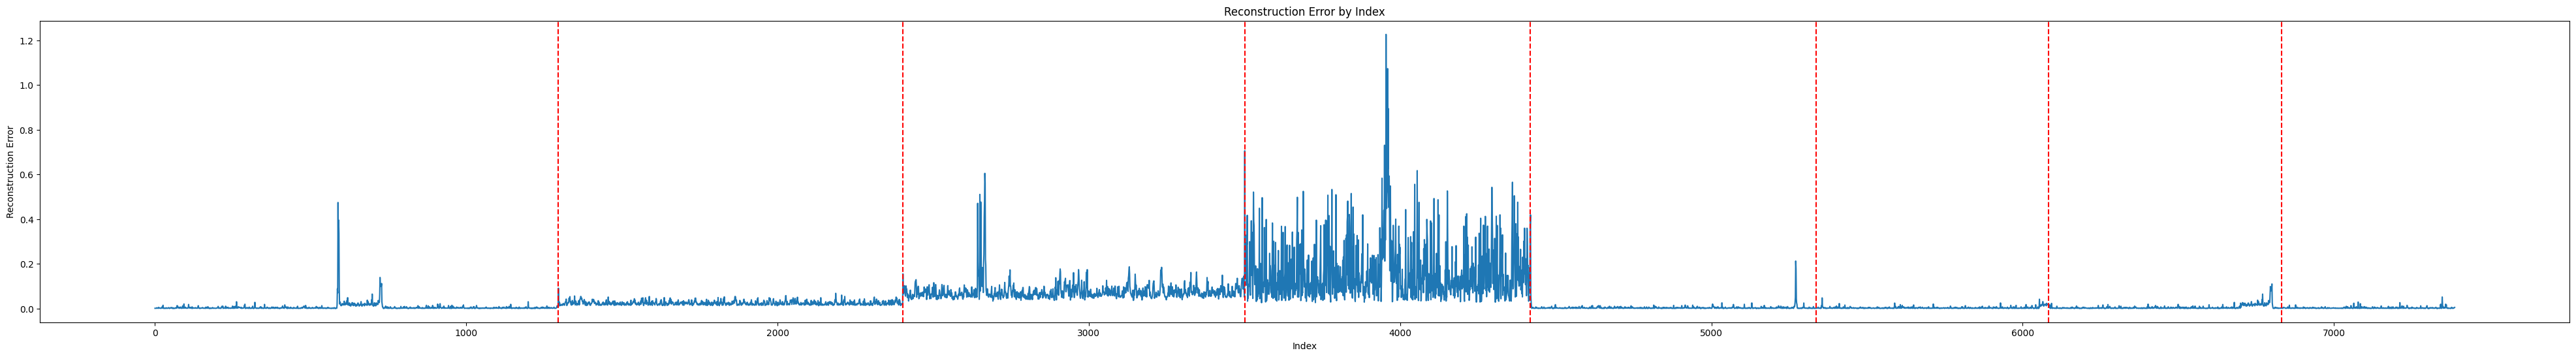

In [50]:
# 인덱스별 reconstruction_error 값을 그래프로 그립니다.
plt.figure(figsize=(50,6))
plt.plot(range(len(reconstruction_error)), reconstruction_error.detach().numpy())
plt.axvline(x=1296, color='r', linestyle='--')
plt.axvline(x=2403, color='r', linestyle='--')
plt.axvline(x=3501, color='r', linestyle='--')
plt.axvline(x=4419, color='r', linestyle='--')
plt.axvline(x=5337, color='r', linestyle='--')
plt.axvline(x=6084, color='r', linestyle='--')
plt.axvline(x=6831, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

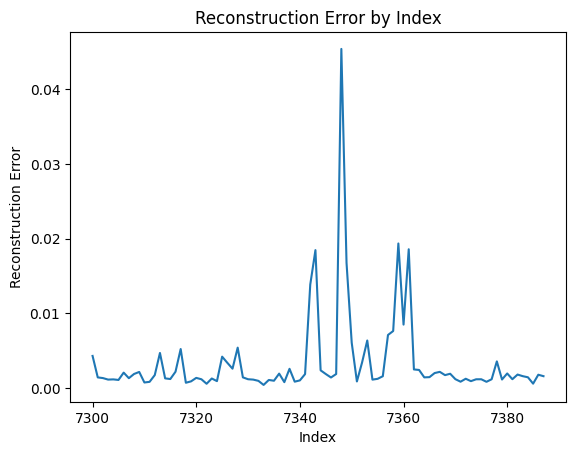

In [39]:
# 인덱스 범위를 설정하여 reconstruction_error 값을 그래프로 그립니다.
start_index = 7300
end_index = 7388
plt.plot(range(start_index, end_index), reconstruction_error[start_index:end_index].detach().numpy())
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

In [ ]:
# Calculate the reconstruction error for test_data
test_data_reconstructed = ae_default(test_data_torch)
reconstruction_error = torch.mean(torch.square(test_data_torch - test_data_reconstructed), axis=1)

# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error.detach().numpy(), 95.34)

# Predict anomalies in test_data
test_predictions = (reconstruction_error.detach().numpy() > threshold).astype(int)

# Feature Importance 확인

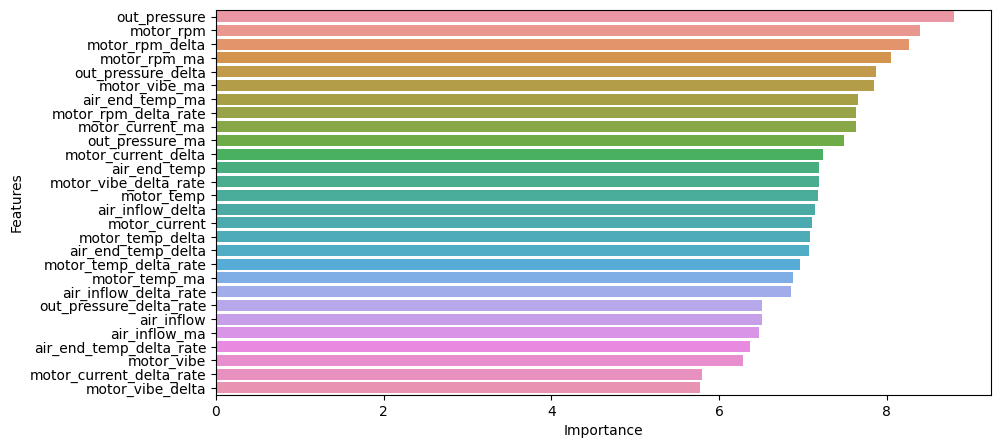

In [59]:
model.load_state_dict(torch.load("timeSeriesFeature_hidden.pth"))

# 가중치 추출
encoder_weights = model.encoder[0].weight.data.numpy()
decoder_weights = model.decoder[0].weight.data.numpy()

# 각 feature의 중요도 계산
importance = np.abs(np.vstack([encoder_weights, decoder_weights[:, :28]])).sum(axis=0)

# 중요도가 높은 feature 순서대로 출력
sorted_idx = np.argsort(importance)[::-1]
feature_names = df_test.columns  # 입력 데이터의 각 열에 대한 이름 리스트
sorted_feature_names = [feature_names[idx] for idx in sorted_idx]
sorted_importance = importance[sorted_idx]

# 중요도가 높은 feature 순서대로 그래프 그리기
plt.figure(figsize=(10, 5))
sns.barplot(y=sorted_feature_names, x=sorted_importance)
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()